# Sample from a branched GP Model

In [1]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import BranchingTree as bt
import BranchingKernels as kernels
np.set_printoptions(precision=4) # precision to print numpy array
import branch_kern as bk

In [2]:
Xs = tf.placeholder("float64")
Ys = tf.placeholder("float64")
ktf = kernels.BranchingKernelTf()
parameterVector = tf.placeholder("float64")

# Generate data for single split kernel

In [3]:
# test all available kernels on single branch example
# Construct a X matrix
N = 3 # how many points per function    
tree = bt.BinaryBranchingTree(0,10,fDebug=False) # set to true to print debug messages
tree.add(None,1,5) # single branching point
(fm, fmb) = tree.GetFunctionBranchTensor()
#print fmb
tree.printTree()    
    
# design matrix
df=tree.GetFunctionDomains()
print 'Function domains, each row contains the lower and upper bound \n of that function. 1-based counting.'
print df
m = df.shape[0] # number of functions
fi=0
domf = df[fi,]
t = np.atleast_2d(np.linspace(domf[0],domf[1],N)).T
x = (fi+1) * np.ones((N,1))
X = np.hstack((t,x))
for fi in range(1,m):
    domf = df[fi,]
    t = np.atleast_2d(np.linspace(domf[0],domf[1],N)).T
    x = (fi+1) * np.ones((N,1))
    X = np.vstack( (X, np.hstack( (t,x)) ) )   
        
    
K_multipleloop_numpy = kernels.KSplitMultipleLoop(X, X, fmb, kernels.rbf, lenscale2B=4)
K_single_numpy = kernels.KSplitSingle(X, X, tree.GetBranchValuesAsArray(), kernels.rbf, lenscale2B=4)

# Tensorflow
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())  # sets all variables
    K_s = ktf.SplitKernel_tf(Xs,Ys)
    K_single_tf=sess.run(K_s,feed_dict={Xs: X, Ys: X, ktf.lenScale:2,ktf.Bs: tree.GetBranchValuesAsArray()})

    # Multiple branch kernel
    K_s_multiple = ktf.KBranchKernel(Xs, Ys, fmb)
    K_multipleloop_tf=sess.run(K_s_multiple, feed_dict={Xs: X, Ys: X, ktf.lenScale:2})
    
assert np.allclose(K_single_numpy,K_multipleloop_numpy)
assert np.allclose(K_single_tf,K_multipleloop_numpy)
assert np.allclose(K_single_tf,K_multipleloop_tf)

Xa = X
Ya = X.copy()

print Xa

------------------1(5)[2,3]
Function domains, each row contains the lower and upper bound 
 of that function. 1-based counting.
[[  0.   5.]
 [  5.  10.]
 [  5.  10.]]
[[  0.    1. ]
 [  2.5   1. ]
 [  5.    1. ]
 [  5.    2. ]
 [  7.5   2. ]
 [ 10.    2. ]
 [  5.    3. ]
 [  7.5   3. ]
 [ 10.    3. ]]


# Compute GPflow branch kernel

In [4]:
#Kbranch = bk.BranchKernel(GPflow.kernels.RBF(D) + GPflow.kernels.White(D), fmb)
#Kbranch.kern.k2.variance = 0.01
kernInsideBranch = GPflow.kernels.RBF(1)
Kbranch = bk.BranchKernel( kernInsideBranch, fmb)
Kbranch.kern.lengthscales = 2
Kbranch.kern.variance = 1
print Kbranch

unnamed.kern.lengthscales transform:+ve prior:None
[ 2.]
unnamed.kern.variance transform:+ve prior:None
[ 1.]


In [5]:
with Kbranch.tf_mode():
    Kbranch.make_tf_array(parameterVector)
    Kbranch_values = Kbranch.K(Xs,Ys)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables()) 
    K_eval = sess.run(Kbranch_values, feed_dict={parameterVector:Kbranch.get_free_state(), Xs:X, Ys:X.copy() })

In [6]:
print K_eval

[[ 1.      0.4578  0.0439  0.0439  0.0201  0.0019  0.0439  0.0201  0.0019]
 [ 0.4578  1.      0.4578  0.4578  0.2096  0.0201  0.4578  0.2096  0.0201]
 [ 0.0439  0.4578  1.      1.      0.4578  0.0439  1.      0.4578  0.0439]
 [ 0.0439  0.4578  1.      1.      0.4578  0.0439  1.      0.4578  0.0439]
 [ 0.0201  0.2096  0.4578  0.4578  1.      0.4578  0.4578  0.2096  0.0201]
 [ 0.0019  0.0201  0.0439  0.0439  0.4578  1.      0.0439  0.0201  0.0019]
 [ 0.0439  0.4578  1.      1.      0.4578  0.0439  1.      0.4578  0.0439]
 [ 0.0201  0.2096  0.4578  0.4578  0.2096  0.0201  0.4578  1.      0.4578]
 [ 0.0019  0.0201  0.0439  0.0439  0.0201  0.0019  0.0439  0.4578  1.    ]]


In [7]:
print K_multipleloop_tf
print K_multipleloop_tf == K_eval

[[ 1.      0.4578  0.0439  0.0439  0.0201  0.0019  0.0439  0.0201  0.0019]
 [ 0.4578  1.      0.4578  0.4578  0.2096  0.0201  0.4578  0.2096  0.0201]
 [ 0.0439  0.4578  1.      1.      0.4578  0.0439  1.      0.4578  0.0439]
 [ 0.0439  0.4578  1.      1.      0.4578  0.0439  1.      0.4578  0.0439]
 [ 0.0201  0.2096  0.4578  0.4578  1.      0.4578  0.4578  0.2096  0.0201]
 [ 0.0019  0.0201  0.0439  0.0439  0.4578  1.      0.0439  0.0201  0.0019]
 [ 0.0439  0.4578  1.      1.      0.4578  0.0439  1.      0.4578  0.0439]
 [ 0.0201  0.2096  0.4578  0.4578  0.2096  0.0201  0.4578  1.      0.4578]
 [ 0.0019  0.0201  0.0439  0.0439  0.0201  0.0019  0.0439  0.4578  1.    ]]
[[ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  

# Generate samples from GP


------------------1(5)[2,3]
Function domains, each row contains the lower and upper bound 
 of that function. 1-based counting.
[[  0.   5.]
 [  5.  10.]
 [  5.  10.]]


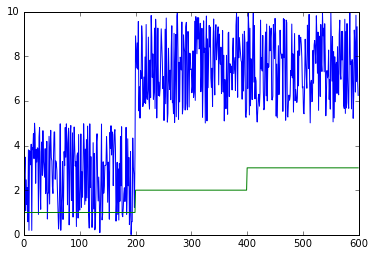

In [29]:
# test all available kernels on single branch example
# Construct a X matrix
N = 200 # how many points per function    
tree = bt.BinaryBranchingTree(0,10,fDebug=False) # set to true to print debug messages
tree.add(None,1,5) # single branching point
(fm, fmb) = tree.GetFunctionBranchTensor()
#print fmb
tree.printTree()    
    
# design matrix
df=tree.GetFunctionDomains()
print 'Function domains, each row contains the lower and upper bound \n of that function. 1-based counting.'
print df
m = df.shape[0] # number of functions
fi=0
domf = df[fi,]
t = np.atleast_2d(domf[0] + (domf[1]-domf[0])*np.random.rand(N)).T
x = (fi+1) * np.ones((N,1))
X = np.hstack((t,x))
for fi in range(1,m):
    domf = df[fi,]
    t = np.atleast_2d(domf[0] + (domf[1]-domf[0])*np.random.rand(N)).T
    x = (fi+1) * np.ones((N,1))
    X = np.vstack( (X, np.hstack( (t,x)) ) )   
plt.plot(X)
#print X

In [30]:
Kbranch = bk.BranchKernel(GPflow.kernels.RBF(1) + GPflow.kernels.White(1), fmb)
Kbranch.kern.k2.variance = .001 # controls the discontinuity magnitude, the gap at the branching point
Kbranch.kern.k1.lengthscales = 2
Kbranch.kern.k1.variance = 1

(600, 2)


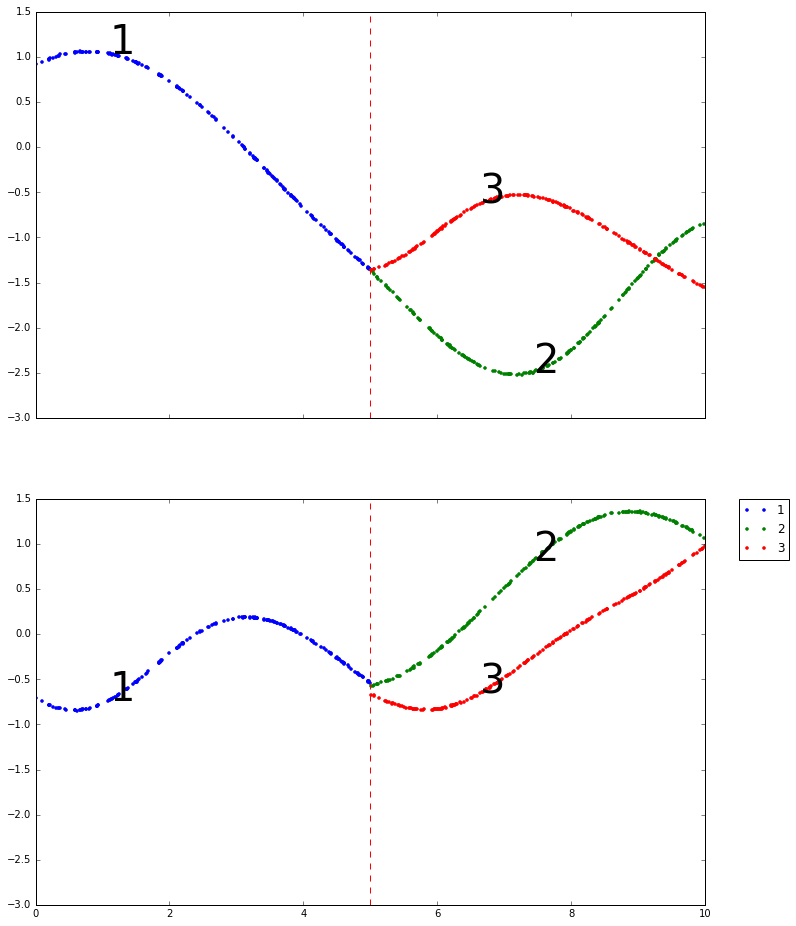

In [31]:
nb = tree.GetNumberOfBranchPts()
M = 2*nb+1 # number of functions
B = tree.GetBranchValuesAsArray().T # get list of branch points

(samples,L,K)=bk.SampleBranchGP(Kbranch,X,M,B,D=2,fPlot=True, lw=3.,fs=40, tol=1e-5)
print samples.shape

6


In [24]:
print inds

[[0, 6], [1, 7], [2, 8], [3, 9], [4, 10], [5, 11]]
